In [3]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cuda:0].
CPU times: user 692 ms, sys: 325 ms, total: 1.02 s
Wall time: 2.45 s


In [4]:
%%time

dataset = create_dataset('criteo', sample_num=100000, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 6.76 s, sys: 1.27 s, total: 8.03 s
Wall time: 10.8 s


In [5]:
class AttentionNet(nn.Module):
    
    def __init__(self, embed_dim=4, t=4):
        super(AttentionNet, self).__init__()
        
        self.an = nn.Sequential(
            nn.Linear(embed_dim, t),  # (batch_size, num_crosses, t), num_crosses = num_fields*(num_fields-1)//2
            nn.ReLU(),
            nn.Linear(t, 1, bias=False), # (batch_size, num_crosses, 1)
            nn.Flatten(),  # (batch_size, num_crosses)
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.an(x)


class AttentionalFactorizationMachine(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(AttentionalFactorizationMachine, self).__init__()
        
        num_fields = len(field_dims)
        
        self.w0 = nn.Parameter(torch.zeros((1, )))
        
        self.embed1 = FeaturesEmbedding(field_dims, 1)
        self.embed2 = FeaturesEmbedding(field_dims, embed_dim)
        self.interact = EmbeddingsInteraction()
        
        self.attention = AttentionNet(embed_dim)
        self.p = nn.Parameter(torch.zeros(embed_dim, ))
        nn.init.xavier_uniform_(self.p.unsqueeze(0).data)
                
    def forward(self, x):
        # x size: (batch_size, num_fields)
        # embed(x) size: (batch_size, num_fields, embed_dim)

        embeddings = self.embed2(x)
        interactions = self.interact(embeddings)
        
        att = self.attention(interactions)
        att_part = interactions.mul(att.unsqueeze(-1)).sum(dim=1).mul(self.p).sum(dim=1, keepdim=True)
        
        output = self.w0 + self.embed1(x).sum(dim=1) + att_part
        output = torch.sigmoid(output)
        
        return output



 53%|█████▎    | 319/600 [09:42<08:32,  1.83s/it]


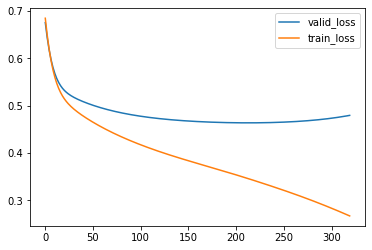

train_loss: 0.34157 | train_metric: 0.90846
valid_loss: 0.46385 | valid_metric: 0.75687
test_loss:  0.44798 | test_auc:  0.76592
CPU times: user 9min 38s, sys: 1.53 s, total: 9min 39s
Wall time: 9min 42s


In [6]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

afm = AttentionalFactorizationMachine(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(afm.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(afm, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))
